In [10]:
from tensorflow.keras.utils import image_dataset_from_directory


In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1


In [12]:

data = f"{path}/data"
import tensorflow as tf
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds_raw.class_names

print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)



Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [13]:
# import matplotlib.pyplot as plt

# for images, labels in train_unhealthy.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy())
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
#     break


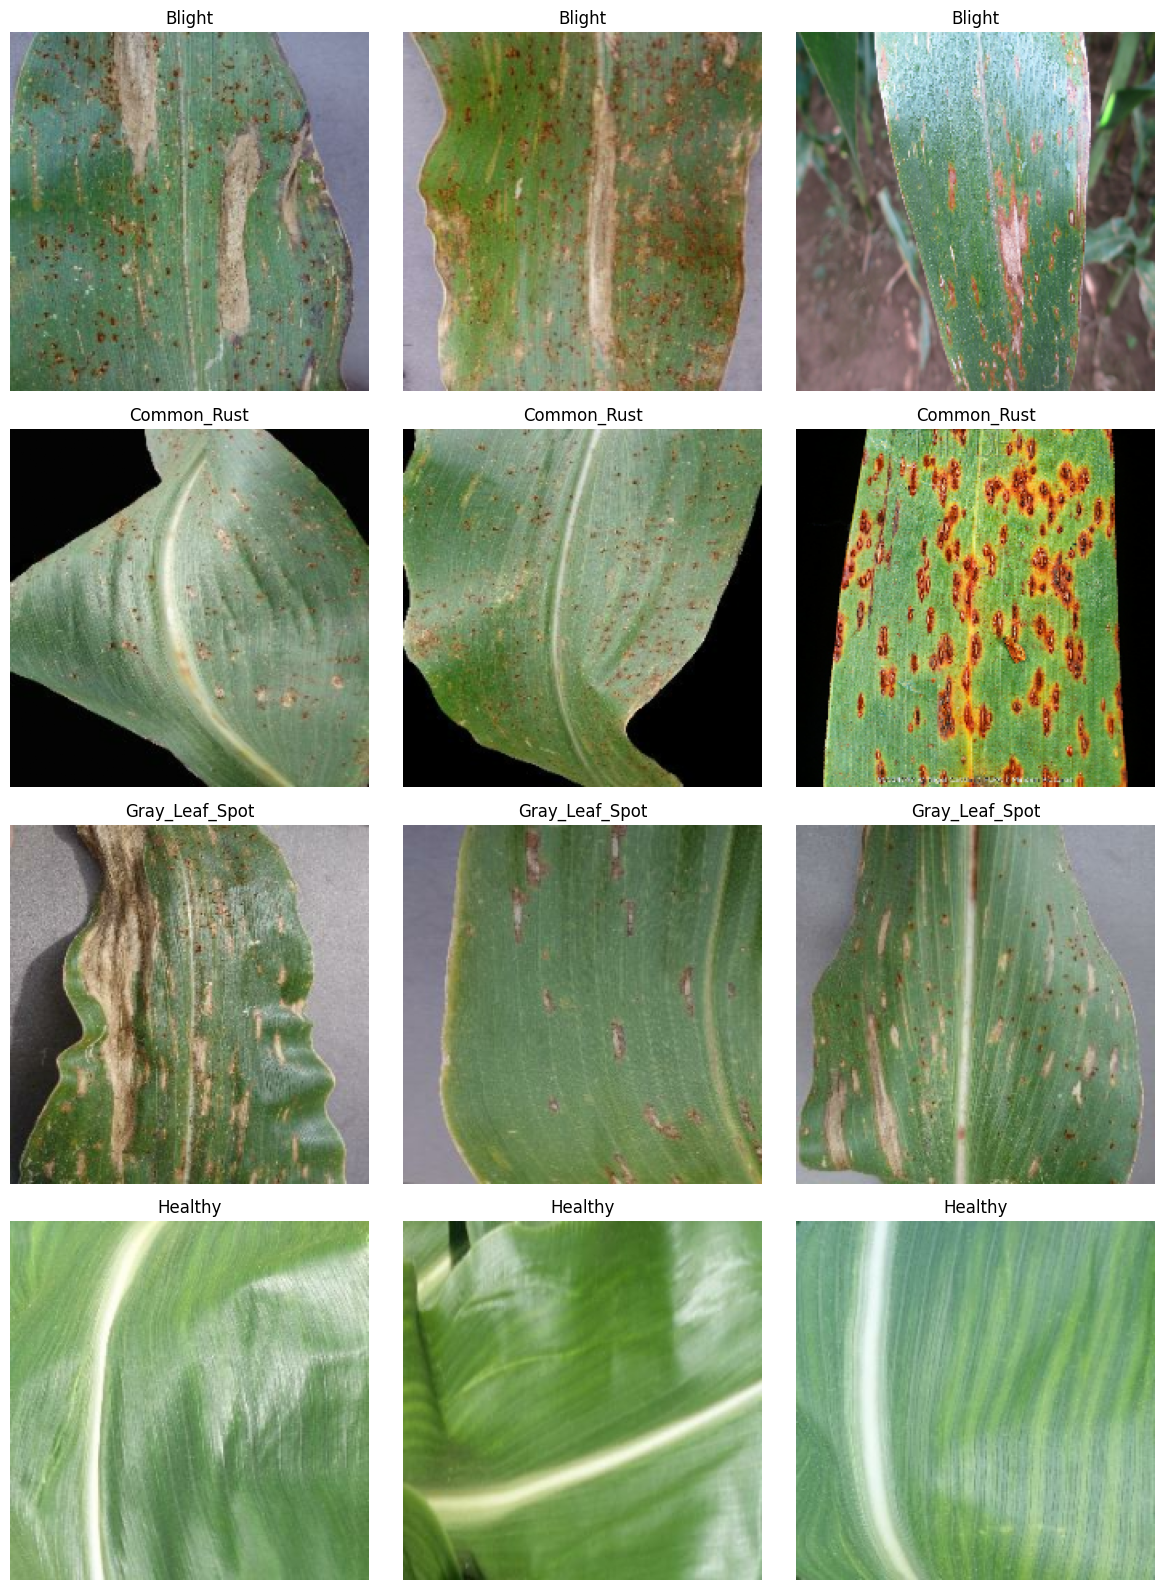

In [14]:
import matplotlib.pyplot as plt

rows = 4       # number of classes
cols = 3       # images per class

# group images by class index
grouped = {i: [] for i in range(len(class_names))}

# Collect images until we have enough per class (3 each)
for images, labels in train_ds.take(1):
    for img, lab in zip(images, labels):
        lab = int(lab.numpy())

        if len(grouped[lab]) < cols:
            grouped[lab].append(img)   # <-- SAME type you used originally

# Plot
plt.figure(figsize=(12, 16))
plot_idx = 1

for class_idx in range(rows):
    imgs = grouped[class_idx]

    for j in range(cols):
        plt.subplot(rows, cols, plot_idx)
        plot_idx += 1

        if j < len(imgs):
            plt.imshow(imgs[j].numpy())     # <-- SAME as your working version
            plt.title(class_names[class_idx])
        else:
            plt.text(0.5, 0.5, "No image", ha="center", va="center")

        plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
# import matplotlib.pyplot as plt

# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy())
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
#     break


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training


In [18]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)


Epoch 1/10


105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 597ms/step - accuracy: 0.8651 - loss: 0.3423 - val_accuracy: 0.9164 - val_loss: 0.2292
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 544ms/step - accuracy: 0.9367 - loss: 0.1634 - val_accuracy: 0.9283 - val_loss: 0.1992
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.9546 - loss: 0.1245 - val_accuracy: 0.9259 - val_loss: 0.2009
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 558ms/step - accuracy: 0.9579 - loss: 0.0979 - val_accuracy: 0.9295 - val_loss: 0.2020
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 544ms/step - accuracy: 0.9752 - loss: 0.0745 - val_accuracy: 0.9271 - val_loss: 0.2216
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.9767 - loss: 0.0609 - val_accuracy: 0.9283 - val_loss: 0.2280
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 538ms/step - accuracy: 0.9875 - loss: 0.0433 - val_accuracy: 0.9164 - val_loss: 0.2457
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.9919 - loss: 0.0315 - val

In [19]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # very low LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)





Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 743ms/step - accuracy: 0.9994 - loss: 0.0104 - val_accuracy: 0.9271 - val_loss: 0.2404
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 675ms/step - accuracy: 0.9994 - loss: 0.0095 - val_accuracy: 0.9259 - val_loss: 0.2424
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 631ms/step - accuracy: 0.9994 - loss: 0.0091 - val_accuracy: 0.9247 - val_loss: 0.2445
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 572ms/step - accuracy: 0.9994 - loss: 0.0086 - val_accuracy: 0.9247 - val_loss: 0.2461
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 74s 703ms/step - accuracy: 0.9994 - loss: 0.0084 - val_accuracy: 0.9247 - val_loss: 0.2474


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# If one-hot encoded labels:
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
# Optional: confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 658ms/step
                precision    recall  f1-score   support

        Blight       0.89      0.88      0.88       225
   Common_Rust       0.96      0.96      0.96       244
Gray_Leaf_Spot       0.80      0.80      0.80       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.92       837
     macro avg       0.91      0.91      0.91       837
  weighted avg       0.92      0.92      0.92       837

[[198   5  21   1]
 [  5 234   5   0]
 [ 19   6 101   0]
 [  1   0   0 241]]



        Blight       0.90      0.88      0.89       225
   Common_Rust       0.97      0.95      0.96       244
Gray_Leaf_Spot       0.79      0.86      0.82       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.93       837
     macro avg       0.92      0.92      0.92       837
  weighted avg       0.93      0.93      0.93       837

[[197   3  24   1]
 [  7 233   4   0]
 [ 14   4 108   0]
 [  1   0   0 241]]

In [21]:
#want to get just accuracy from model
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)
print('Loss:', loss)

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - accuracy: 0.9247 - loss: 0.2474
Validation Accuracy: 0.9247311949729919
Loss: 0.24736523628234863


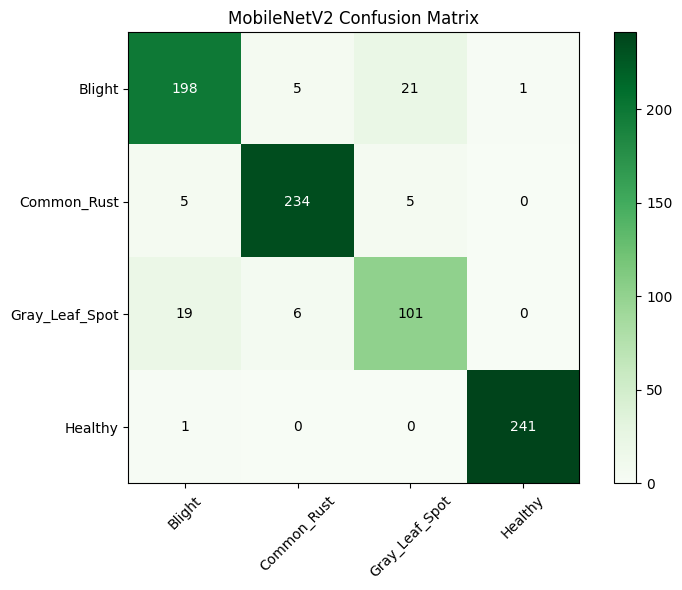

In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Greens')
plt.title('MobileNetV2 Confusion Matrix')
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()